In [1]:
from helper import*
import params as cfg

In [2]:
"Functions utilized in this script"
def multipleFilesNotch(input_3d,fs):
    notch_out = []
    filtering = filters()
    for i in range(input_3d.shape[0]):
        notch_out.append(filtering.notch(input_3d[i,:,:],fs))
    return np.array(notch_out)

def multipleFilesbutterBandpass(input_3d,lowcut,highcut,fs):
    butter_out = []
    filtering = filters()
    for i in range(input_3d.shape[0]):
        butter_out.append(filtering.butterBandPass(input_3d[i,:,:],lowcut,highcut,fs))
    return np.array(butter_out)

def multipleArtfRemoval(input_3d,threshold_value,timearray,len_window,step_size,choice_numwindows,channels,group):
    print(group)
    artf_out = []
    for i in range(input_3d.shape[0]):
        artf_out.append(ar_maximumgradient(input_3d[i,:,:],threshold_value,timearray,len_window,step_size,choice_numwindows,channels))
    print('***************************************************************************************************************************************************************')
    return np.array(artf_out)

def multiplePSD(data_4D,fs):
    freqs,psd = [],[]
    for i in range(data_4D.shape[0]):
        freqs.append(computePSD(data_4D[i],fs,data_type='3D')[0])
        psd.append(computePSD(data_4D[i],fs,data_type='3D')[1])
    psd = np.array(psd)
    freqs = np.array(freqs)
    return freqs,psd

def specgram_features(data,sfreq,NFFT,Noverlap,time,data_shape):

    def params_1D(data_1D,fs,win_len,win_overlap,spec_time): 
        s_px,s_fx,s_tx,s_imx = plt.specgram(data_1D, NFFT=win_len, Fs=fs, noverlap=win_overlap)
        s_tx = np.linspace(spec_time[0],spec_time[1],len(s_px.T))
        return s_px,s_fx,s_tx

    def params_2D(data_2D,sfreq,nfft,noverlap,spec_time):
#        input: data must be windowed to form 2D array
#               data_2D = (len_windows,num_windows)
#               sfreq = sampling frequency
#               nfft = number of points to use in the FFT
#               noverlap = number of points to overlap
            
#        output: psd = (len_freqs,len_time), freqs = (len_freqs,), time = (len_time,)

        psd,freqs,times = [],[],[]
        for i in range(len(data_2D.T)):
            s_px,s_fx,s_tx = params_1D(data_2D[:,i],sfreq,nfft,noverlap,spec_time)
            psd.append(s_px)
            freqs.append(s_fx)
            times.append(s_tx)
        psd,freqs,times = np.array(psd),np.array(freqs),np.array(times)
        psd = np.nanmean(psd,axis=0)
        return psd,freqs,times

    def params_3D(data_3D,sfreq,nfft,noverlap,spec_time):
#        input: data must be windowed to form 3D array
#               data_3D = (num_channels,len_windows,num_windows)
#               sfreq = sampling frequency
#               nfft = number of points to use in the FFT
#               noverlap = number of points to overlap
            
#        output: psd = (num_channels,len_freqs,len_time), freqs = (len_freqs,), time = (len_time,)

        psd,freqs,times = [],[],[]
        for i in range(data_3D.shape[0]):
            s_px,s_fx,s_tx = params_2D(data_3D[i,:,:],sfreq,nfft,noverlap,spec_time)
            psd.append(s_px)
            freqs.append(s_fx)
            times.append(s_tx)
        psd,freqs,times = np.array(psd),np.array(freqs),np.array(times)
        return psd,freqs,times

    def params_4D(data_4D,sfreq,nfft,noverlap,spec_time):
#        input: data must be windowed to form 4D array
#               data_4D = (num_participants,num_channels,len_windows,num_windows)
#               sfreq = sampling frequency
#               nfft = number of points to use in the FFT
#               noverlap = number of points to overlap
            
#        output: psd = (num_participants,num_channels,len_freqs,len_time), freqs = (len_freqs,), time = (len_time,)
        psd,freqs,times = [],[],[]
        for i in range(data_4D.shape[0]):
            s_px,s_fx,s_tx = params_3D(data_4D[i,:,:,:],sfreq,nfft,noverlap,spec_time)
            psd.append(s_px)
            freqs.append(s_fx)
            times.append(s_tx)
        psd,freqs,times = np.array(psd),np.array(freqs),np.array(times)
        return psd,freqs,times
    
    if data_shape == '1D':
        s_psd,s_freqs,s_times = params_1D(data,sfreq,NFFT,Noverlap,time)
    elif data_shape == '2D':
        s_psd,s_freqs,s_times = params_2D(data,sfreq,NFFT,Noverlap,time)
    elif data_shape == '3D':
        s_psd,s_freqs,s_times = params_3D(data,sfreq,NFFT,Noverlap,time)
    elif data_shape == '4D':
        s_psd,s_freqs,s_times = params_4D(data,sfreq,NFFT,Noverlap,time)
    return s_psd,s_freqs,s_times

In [3]:
#   Group-Task-Time
M11 = ['m11_1.zip','m11_2.zip','m11_3.zip','m11_4.zip','m11_5.zip']
M21 = ['m21_1.zip','m21_2.zip','m21_3.zip','m21_4.zip','m21_5.zip']
M12 = ['m12_1.zip','m12_2.zip','m12_3.zip','m12_4.zip','m12_5.zip']
M22 = ['m22_1.zip','m22_2.zip','m22_3.zip','m22_4.zip','m22_5.zip']
C11 = ['c11_1.zip','c11_2.zip','c11_3.zip','c11_4.zip','c11_5.zip']
C21 = ['c21_1.zip','c21_2.zip','c21_3.zip','c21_4.zip','c21_5.zip']
C12 = ['c12_1.zip','c12_2.zip','c12_3.zip','c12_4.zip','c12_5.zip']
C22 = ['c22_1.zip','c22_2.zip','c22_3.zip','c22_4.zip','c22_5.zip']
localDir = "/Users/joshuaighalo/Documents/datasets/eeg/v2/"
destDir = "/Users/joshuaighalo/Documents/datasets/eeg/v2/dest/"
os.system('rm -rf %s/*' % destDir)
fs_setting = 'constant'

In [4]:
"""
#   Group-Task-Time Ryan SEEN
M11 = ['m11_1.zip','m11_2.zip','m11_3.zip','m11_4.zip','m11_5.zip']
C21 = ['m21_1.zip','m21_2.zip','m21_3.zip','m21_4.zip','m21_5.zip']
M12 = ['m12_1.zip','m12_2.zip','m12_3.zip','m12_4.zip','m12_5.zip']
C22 = ['m22_1.zip','m22_2.zip','m22_3.zip','m22_4.zip','m22_5.zip']
C11 = ['c11_1.zip','c11_2.zip','c11_3.zip','c11_4.zip','c11_5.zip']
M21 = ['c21_1.zip','c21_2.zip','c21_3.zip','c21_4.zip','c21_5.zip']
C12 = ['c12_1.zip','c12_2.zip','c12_3.zip','c12_4.zip','c12_5.zip']
M22 = ['c22_1.zip','c22_2.zip','c22_3.zip','c22_4.zip','c22_5.zip']
localDir = "/Users/joshuaighalo/Documents/datasets/eeg/v2/"
destDir = "/Users/joshuaighalo/Documents/datasets/eeg/v2/dest/"
os.system('rm -rf %s/*' % destDir)
fs_setting = 'constant'
"""

'\n#   Group-Task-Time Ryan SEEN\nM11 = [\'m11_1.zip\',\'m11_2.zip\',\'m11_3.zip\',\'m11_4.zip\',\'m11_5.zip\']\nC21 = [\'m21_1.zip\',\'m21_2.zip\',\'m21_3.zip\',\'m21_4.zip\',\'m21_5.zip\']\nM12 = [\'m12_1.zip\',\'m12_2.zip\',\'m12_3.zip\',\'m12_4.zip\',\'m12_5.zip\']\nC22 = [\'m22_1.zip\',\'m22_2.zip\',\'m22_3.zip\',\'m22_4.zip\',\'m22_5.zip\']\nC11 = [\'c11_1.zip\',\'c11_2.zip\',\'c11_3.zip\',\'c11_4.zip\',\'c11_5.zip\']\nM21 = [\'c21_1.zip\',\'c21_2.zip\',\'c21_3.zip\',\'c21_4.zip\',\'c21_5.zip\']\nC12 = [\'c12_1.zip\',\'c12_2.zip\',\'c12_3.zip\',\'c12_4.zip\',\'c12_5.zip\']\nM22 = [\'c22_1.zip\',\'c22_2.zip\',\'c22_3.zip\',\'c22_4.zip\',\'c22_5.zip\']\nlocalDir = "/Users/joshuaighalo/Documents/datasets/eeg/v2/"\ndestDir = "/Users/joshuaighalo/Documents/datasets/eeg/v2/dest/"\nos.system(\'rm -rf %s/*\' % destDir)\nfs_setting = \'constant\'\n'

In [5]:
#   Extract eeg data from participants within the groups
M11 = zipExtract(M11,localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
M21 = zipExtract(M21,localDir,destDir,"M21",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
M12 = zipExtract(M12,localDir,destDir,"M12",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
M22 = zipExtract(M22,localDir,destDir,"M22",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
C11 = zipExtract(C11,localDir,destDir,"C11",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
C21 = zipExtract(C21,localDir,destDir,"C21",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
C12 = zipExtract(C12,localDir,destDir,"C12",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
C22 = zipExtract(C22,localDir,destDir,"C22",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
time_s = np.arange(0,cfg.collection_time,1/cfg.fs)

In [6]:
#   Notch filters data collected from participants
noc_M11 = multipleFilesNotch(M11,cfg.fs)
noc_M21 = multipleFilesNotch(M21,cfg.fs)
noc_M12 = multipleFilesNotch(M12,cfg.fs)
noc_M22 = multipleFilesNotch(M22,cfg.fs)
noc_C11 = multipleFilesNotch(C11,cfg.fs)
noc_C21 = multipleFilesNotch(C21,cfg.fs)
noc_C12 = multipleFilesNotch(C12,cfg.fs)
noc_C22 = multipleFilesNotch(C22,cfg.fs)

In [7]:
#   Bandpass filters data collected from participants
band_M11 = multipleFilesbutterBandpass(noc_M11,cfg.lowcut,cfg.highcut,cfg.fs)
band_M21 = multipleFilesbutterBandpass(noc_M21,cfg.lowcut,cfg.highcut,cfg.fs)
band_M12 = multipleFilesbutterBandpass(noc_M12,cfg.lowcut,cfg.highcut,cfg.fs)
band_M22 = multipleFilesbutterBandpass(noc_M22,cfg.lowcut,cfg.highcut,cfg.fs)
band_C11 = multipleFilesbutterBandpass(noc_C11,cfg.lowcut,cfg.highcut,cfg.fs)
band_C21 = multipleFilesbutterBandpass(noc_C21,cfg.lowcut,cfg.highcut,cfg.fs)
band_C12 = multipleFilesbutterBandpass(noc_C12,cfg.lowcut,cfg.highcut,cfg.fs)
band_C22 = multipleFilesbutterBandpass(noc_C22,cfg.lowcut,cfg.highcut,cfg.fs)

In [8]:
def artifact_removal_2d(data,window_size,maxgrad_threshold,choice_num_windows):
    #   This function removes artifacts from the data
    #   data: data to be cleaned (2D array:num_samples x num_channels)
    #   window_size: size of the window in seconds
    #   maxgrad_threshold: threshold for maximum gradient
    #   choice_num_windows: number of windows to use
    #   return: cleaned data (channels,window_len,choice_num_windows)
    
    def maximum_gradient(data,data_shape):
        def maxgrad1D(data):
            return np.max(np.abs(np.diff(data)))
        def maxgrad2D(data2D):
            diff_succ_val = []
            for i in range(len(data2D.T)):
                diff_succ_val.append(maxgrad1D(data2D[:,i]))
            return np.array(diff_succ_val)
        def maxgrad3D(data3D):
            diff_succ_val = []
            for i in range(len(data3D)):
                diff_succ_val.append(maxgrad2D(data3D[i]))
            return np.array(diff_succ_val)
        def maxgrad4D(data4D):
            diff_succ_val = []
            for i in range(len(data4D)):
                diff_succ_val.append(maxgrad3D(data4D[i]))
            return np.array(diff_succ_val)
        if data_shape == '1D':
            return maxgrad1D(data)
        elif data_shape == '2D':
            return maxgrad2D(data)
        elif data_shape == '3D':
            return maxgrad3D(data)
        elif data_shape == '4D':
            return maxgrad4D(data)
        
    def slidingwindow(data_1D,timing_array,window_size,step_size):
        idx_winsize = np.where(timing_array == window_size)[0][0]
        idx_stepsize = np.where(timing_array == step_size)[0][0]
        frame_len, hop_len = idx_winsize,idx_stepsize
        frames = librosa.util.frame(data_1D, frame_length=frame_len, hop_length=hop_len)
        windowed_frames = (np.hanning(frame_len).reshape(-1, 1)*frames).T
        return windowed_frames

    step_size = window_size
    window_output = np.zeros(len(data))
    window_output[window_output == 0] = np.nan
    window_output = slidingwindow(window_output,time_s,window_size,step_size)
    for i in range(len(data.T)):
        window_output = np.dstack((window_output,slidingwindow(data.T[i],time_s,window_size,step_size)))
    window_output = np.transpose(window_output,(2,1,0))
    window_output = np.delete(window_output,0,0)

    maxgrad_window = maximum_gradient(window_output,'3D')
    # convert max grad values greater than threshold to nans
    maxgrad_window[maxgrad_window > maxgrad_threshold] = np.nan

    if choice_num_windows == 'all':
        # extract indices of none nan values
        idx_chan_1 = np.where(~np.isnan(maxgrad_window[0]))[0]
        idx_chan_2 = np.where(~np.isnan(maxgrad_window[1]))[0]
        idx_chan_3 = np.where(~np.isnan(maxgrad_window[2]))[0]
        idx_chan_4 = np.where(~np.isnan(maxgrad_window[3]))[0]
        # extract windows with none nan values indices
        best_window_1 = window_output[0][:,idx_chan_1]
        best_window_2 = window_output[1][:,idx_chan_2]
        best_window_3 = window_output[2][:,idx_chan_3] 
        best_window_4 = window_output[3][:,idx_chan_4]
        print('best_window_1.shape',best_window_1.shape)
        print('best_window_2.shape',best_window_2.shape)
        print('best_window_3.shape',best_window_3.shape)
        print('best_window_4.shape',best_window_4.shape)
        remain_windows_1 = window_output.shape[2]-len(idx_chan_1)
        remain_windows_1 = np.full((best_window_1.shape[0],remain_windows_1),np.nan)
        remain_windows_2 = window_output.shape[2]-len(idx_chan_2)
        remain_windows_2 = np.full((best_window_2.shape[0],remain_windows_2),np.nan)
        remain_windows_3 = window_output.shape[2]-len(idx_chan_3)
        remain_windows_3 = np.full((best_window_3.shape[0],remain_windows_3),np.nan)
        remain_windows_4 = window_output.shape[2]-len(idx_chan_4)
        remain_windows_4 = np.full((best_window_4.shape[0],remain_windows_4),np.nan)
        print('remain_windows_1',remain_windows_1.shape)
        print('remain_windows_2',remain_windows_2.shape)
        print('remain_windows_3',remain_windows_3.shape)
        print('remain_windows_4',remain_windows_4.shape)
        best_window_1 = np.concatenate((best_window_1,remain_windows_1),axis=1)
        print('best_window_1.shape',best_window_1.shape)
        best_window_2 = np.concatenate((best_window_2,remain_windows_2),axis=1)
        print('best_window_2.shape',best_window_2.shape)
        best_window_3 = np.concatenate((best_window_3,remain_windows_3),axis=1)
        print('best_window_3.shape',best_window_3.shape)
        best_window_4 = np.concatenate((best_window_4,remain_windows_4),axis=1)
        print('best_window_4.shape',best_window_4.shape)
        # combine windows
        best_window_channels = np.stack((best_window_1,best_window_2,best_window_3,best_window_4))

    if choice_num_windows != 'all':
        num_nan_wins_1, num_nan_wins_2, num_nan_wins_3, num_nan_wins_4 = np.sum(~np.isnan(maxgrad_window[0])), np.sum(~np.isnan(maxgrad_window[1])), np.sum(~np.isnan(maxgrad_window[2])), np.sum(~np.isnan(maxgrad_window[3]))
        num_nan_wins = np.array([num_nan_wins_1,num_nan_wins_2,num_nan_wins_3,num_nan_wins_4])
        if choice_num_windows < num_nan_wins.min():
            print('Number of windows chosen is less than the number of none null windows in all channels')
            idx_chan_1 = np.argsort(maxgrad_window[0])[:choice_num_windows]
            idx_chan_2 = np.argsort(maxgrad_window[1])[:choice_num_windows]
            idx_chan_3 = np.argsort(maxgrad_window[2])[:choice_num_windows]
            idx_chan_4 = np.argsort(maxgrad_window[3])[:choice_num_windows]
            # extract windows with top 75 lowest max grad values indices
            best_window_1 = window_output[0][:,idx_chan_1]
            best_window_2 = window_output[1][:,idx_chan_2]
            best_window_3 = window_output[2][:,idx_chan_3]
            best_window_4 = window_output[3][:,idx_chan_4]
            # combine windows
            best_window_channels = np.stack((best_window_1,best_window_2,best_window_3,best_window_4))
        else:
            print('Number of windows chosen is greater than the number of none null windows in one or more channels:')
            if num_nan_wins.min()>50:
                print('choice number of windows selected')
                idx_chan_1 = np.argsort(maxgrad_window[0])[:num_nan_wins.min()]
                idx_chan_2 = np.argsort(maxgrad_window[1])[:num_nan_wins.min()]
                idx_chan_3 = np.argsort(maxgrad_window[2])[:num_nan_wins.min()]
                idx_chan_4 = np.argsort(maxgrad_window[3])[:num_nan_wins.min()]
                # extract windows with top 75 lowest max grad values indices
                best_window_1 = window_output[0][:,idx_chan_1]
                best_window_2 = window_output[1][:,idx_chan_2]
                best_window_3 = window_output[2][:,idx_chan_3]
                best_window_4 = window_output[3][:,idx_chan_4]
                # combine windows
                best_window_channels = np.stack((best_window_1,best_window_2,best_window_3,best_window_4))
            if num_nan_wins.min()<=50:
                print('choice number of windows not available, data discarded (null-filled)')
                best_window_1 = np.full((window_output.shape[1],choice_num_windows),np.nan)
                best_window_2 = np.full((window_output.shape[1],choice_num_windows),np.nan)
                best_window_3 = np.full((window_output.shape[1],choice_num_windows),np.nan)
                best_window_4 = np.full((window_output.shape[1],choice_num_windows),np.nan)
                # combine windows
                best_window_channels = np.stack((best_window_1,best_window_2,best_window_3,best_window_4))
            
    return best_window_channels
               
def artifact_removal_3d(data_3d,window_size,maxgrad_threshold,choice_num_windows):
    # data_3d = (subjects x num_samples x num_channels)
    # window_size = size of window in seconds
    # maxgrad_threshold = threshold for maximum gradient
    # choice_num_windows = number of windows to choose from
    # output = (subjects x num_channels x window_size x num_windows)
    output = []
    for i in range(data_3d.shape[0]):
        output.append(artifact_removal_2d(data_3d[i,:,:],window_size,maxgrad_threshold,choice_num_windows))
    return np.array(output)

window_size,maxgrad_threshold,choice_num_windows = 0.5,5,'all'
arr_M11 = artifact_removal_3d(band_M11,window_size,maxgrad_threshold,choice_num_windows)
print("M11 done:",arr_M11.shape)
arr_M12 = artifact_removal_3d(band_M12,window_size,maxgrad_threshold,choice_num_windows)
print("M12 done:",arr_M12.shape)
arr_M21 = artifact_removal_3d(band_M21,window_size,maxgrad_threshold,choice_num_windows)
print("M21 done:",arr_M21.shape)
arr_M22 = artifact_removal_3d(band_M22,window_size,maxgrad_threshold,choice_num_windows)
print("M22 done:",arr_M22.shape)
arr_C11 = artifact_removal_3d(band_C11,window_size,maxgrad_threshold,choice_num_windows)
print("C11 done:",arr_C11.shape)
arr_C12 = artifact_removal_3d(band_C12,window_size,maxgrad_threshold,choice_num_windows)
print("C12 done:",arr_C12.shape)
arr_C21 = artifact_removal_3d(band_C21,window_size,maxgrad_threshold,choice_num_windows)
print("C21 done:",arr_C21.shape)
arr_C22 = artifact_removal_3d(band_C22,window_size,maxgrad_threshold,choice_num_windows)
print("C22 done:",arr_C22.shape)

best_window_1.shape (128, 113)
best_window_2.shape (128, 228)
best_window_3.shape (128, 237)
best_window_4.shape (128, 6)
remain_windows_1 (128, 127)
remain_windows_2 (128, 12)
remain_windows_3 (128, 3)
remain_windows_4 (128, 234)
best_window_1.shape (128, 240)
best_window_2.shape (128, 240)
best_window_3.shape (128, 240)
best_window_4.shape (128, 240)
best_window_1.shape (128, 81)
best_window_2.shape (128, 228)
best_window_3.shape (128, 215)
best_window_4.shape (128, 88)
remain_windows_1 (128, 159)
remain_windows_2 (128, 12)
remain_windows_3 (128, 25)
remain_windows_4 (128, 152)
best_window_1.shape (128, 240)
best_window_2.shape (128, 240)
best_window_3.shape (128, 240)
best_window_4.shape (128, 240)
best_window_1.shape (128, 70)
best_window_2.shape (128, 211)
best_window_3.shape (128, 222)
best_window_4.shape (128, 7)
remain_windows_1 (128, 170)
remain_windows_2 (128, 29)
remain_windows_3 (128, 18)
remain_windows_4 (128, 233)
best_window_1.shape (128, 240)
best_window_2.shape (128, 2

## Frequency Domain

<b>Extract PSD, Frequencies and Time from spectrogram

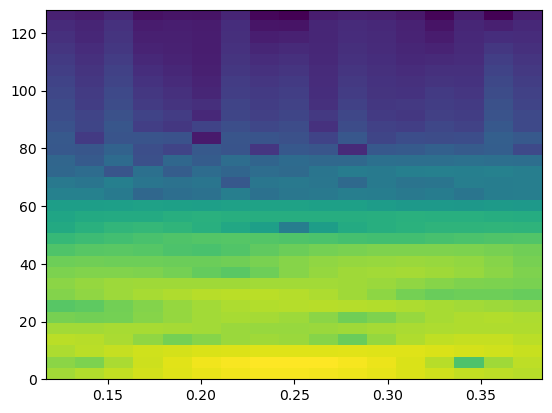

In [9]:
fs,nfft,overlap,spectral_time = 256,64,60,[0,500]
s_pxM11,s_fxM11,s_txM11 = specgram_features(arr_M11,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxM12,s_fxM12,s_txM12 = specgram_features(arr_M12,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxM21,s_fxM21,s_txM21 = specgram_features(arr_M21,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxM22,s_fxM22,s_txM22 = specgram_features(arr_M22,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxC11,s_fxC11,s_txC11 = specgram_features(arr_C11,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxC12,s_fxC12,s_txC12 = specgram_features(arr_C12,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxC21,s_fxC21,s_txC21 = specgram_features(arr_C21,fs,nfft,overlap,spectral_time,data_shape='4D')
s_pxC22,s_fxC22,s_txC22 = specgram_features(arr_C22,fs,nfft,overlap,spectral_time,data_shape='4D')

In [10]:
#  Average power bins across participants
meanpar_pxM11,meanpar_pxM12,meanpar_pxM21,meanpar_pxM22 = np.nanmean(s_pxM11,axis=0),np.nanmean(s_pxM12,axis=0),np.nanmean(s_pxM21,axis=0),np.nanmean(s_pxM22,axis=0)
meanpar_pxC11,meanpar_pxC12,meanpar_pxC21,meanpar_pxC22 = np.nanmean(s_pxC11,axis=0),np.nanmean(s_pxC12,axis=0),np.nanmean(s_pxC21,axis=0),np.nanmean(s_pxC22,axis=0)

## Visualization: Average across all channels

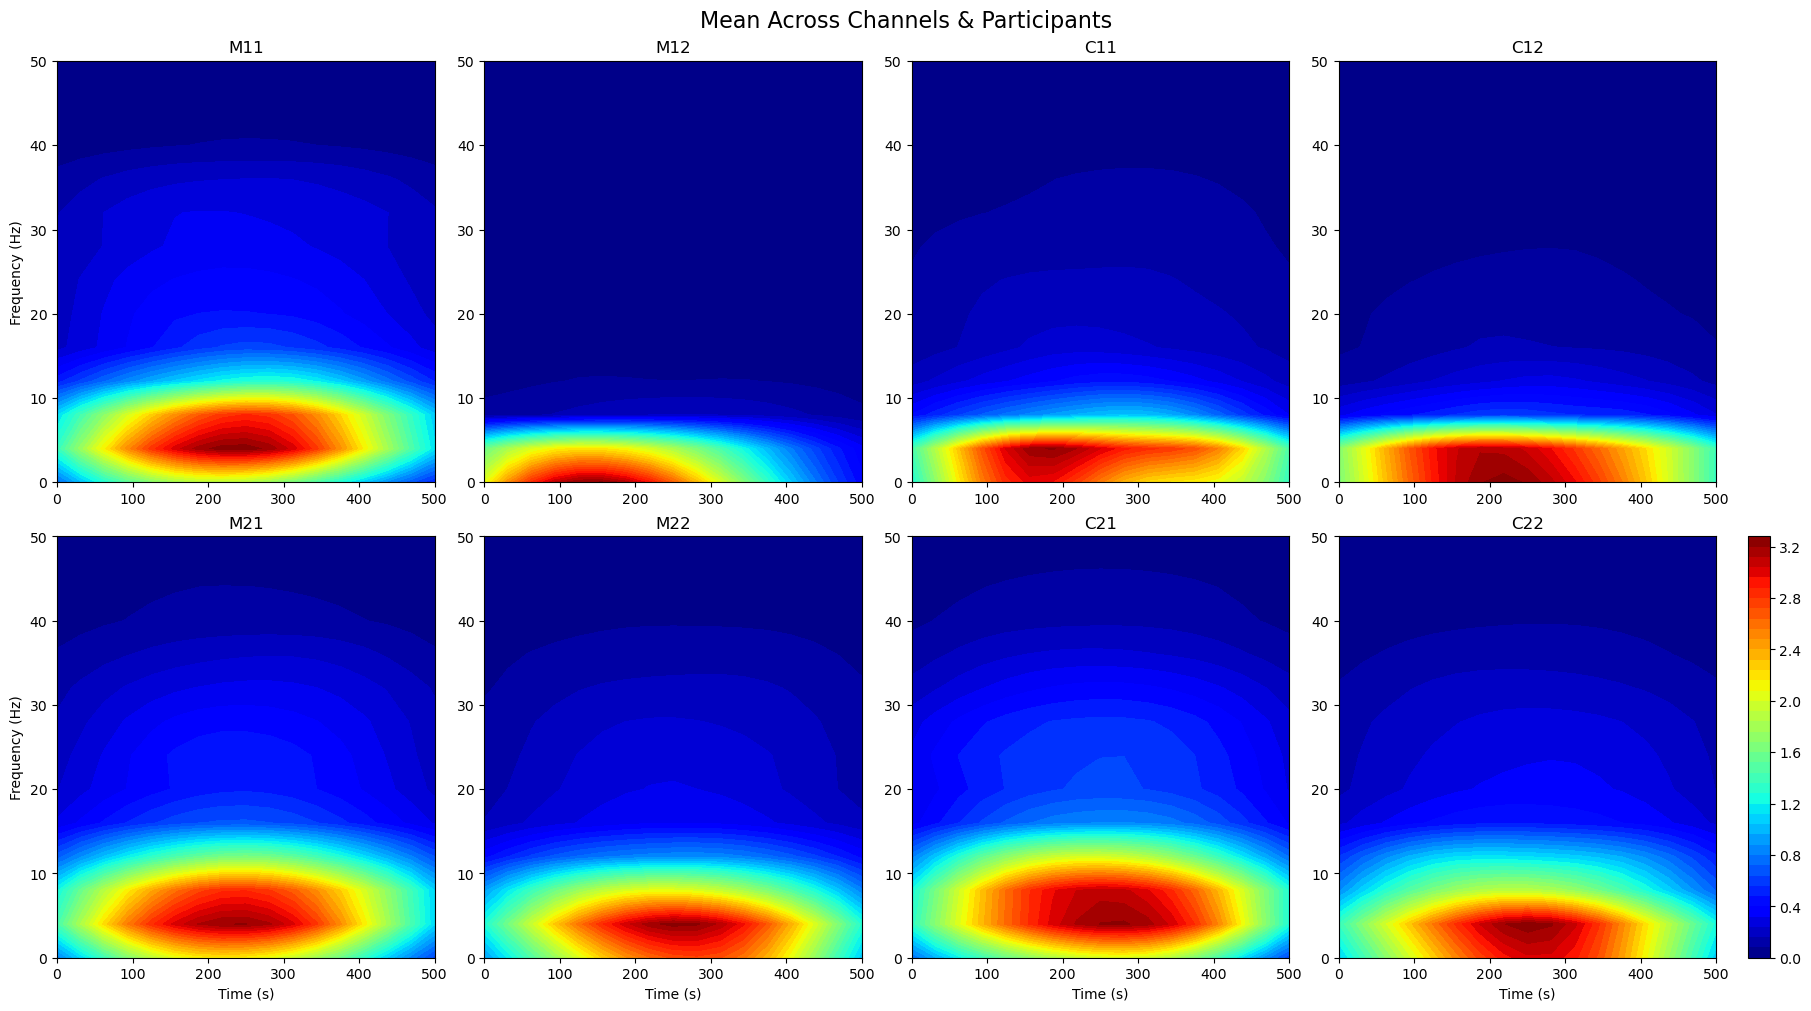

In [11]:
#  Average power bins across participants and channels
meanparchan_pxM11,meanparchan_pxM12,meanparchan_pxM21,meanparchan_pxM22 = np.nanmean(meanpar_pxM11,axis=0),np.nanmean(meanpar_pxM12,axis=0),np.nanmean(meanpar_pxM21,axis=0),np.nanmean(meanpar_pxM22,axis=0)
meanparchan_pxC11,meanparchan_pxC12,meanparchan_pxC21,meanparchan_pxC22 = np.nanmean(meanpar_pxC11,axis=0),np.nanmean(meanpar_pxC12,axis=0),np.nanmean(meanpar_pxC21,axis=0),np.nanmean(meanpar_pxC22,axis=0)
freqs,time = s_fxM11[0,0,0,:],s_txM11[0,0,0,:]

fig, ax = plt.subplots(2,4, figsize=(18,10), constrained_layout=True)
fig.suptitle('Mean Across Channels & Participants', fontsize=16)
ax[0,0].set_title('M11')
ax[0,1].set_title('M12')
ax[0,2].set_title('C11')
ax[0,3].set_title('C12')
ax[1,0].set_title('M21')
ax[1,1].set_title('M22')
ax[1,2].set_title('C21')
ax[1,3].set_title('C22')
ax[0,0].set_ylabel('Frequency (Hz)')
ax[1,0].set_ylabel('Frequency (Hz)')
ax[1,0].set_xlabel('Time (s)')
ax[1,1].set_xlabel('Time (s)')
ax[1,2].set_xlabel('Time (s)')
ax[1,3].set_xlabel('Time (s)')
ax[0,0].set_ylim(0,50)
ax[0,1].set_ylim(0,50)
ax[0,2].set_ylim(0,50)
ax[0,3].set_ylim(0,50)
ax[1,0].set_ylim(0,50)
ax[1,1].set_ylim(0,50)
ax[1,2].set_ylim(0,50)
ax[1,3].set_ylim(0,50)
levels = 50
spectrum = ax[0,0].contourf(time, freqs, meanparchan_pxM11,levels,cmap='jet')
spectrum = ax[0,1].contourf(time, freqs, meanparchan_pxM12,levels,cmap='jet')
spectrum = ax[0,2].contourf(time, freqs, meanparchan_pxC11,levels,cmap='jet')
spectrum = ax[0,3].contourf(time, freqs, meanparchan_pxC12,levels,cmap='jet')
spectrum = ax[1,0].contourf(time, freqs, meanparchan_pxM21,levels,cmap='jet')
spectrum = ax[1,1].contourf(time, freqs, meanparchan_pxM22,levels,cmap='jet')
spectrum = ax[1,2].contourf(time, freqs, meanparchan_pxC21,levels,cmap='jet')
spectrum = ax[1,3].contourf(time, freqs, meanparchan_pxC22,levels,cmap='jet')
cbar = plt.colorbar(spectrum)
plt.show()

## Visualization: Average across hemispheres

In [12]:
hleftM11,hrightM11,hleftM12,hrightM12 = np.nanmean(meanpar_pxM11[0:2,:],axis=0),np.nanmean(meanpar_pxM11[2:4,:],axis=0),np.nanmean(meanpar_pxM12[0:2,:],axis=0),np.nanmean(meanpar_pxM12[2:4,:],axis=0)
hleftC11,hrightC11,hleftC12,hrightC12 = np.nanmean(meanpar_pxC11[0:2,:],axis=0),np.nanmean(meanpar_pxC11[2:4,:],axis=0),np.nanmean(meanpar_pxC12[0:2,:],axis=0),np.nanmean(meanpar_pxC12[2:4,:],axis=0)
hleftM21,hrightM21,hleftM22,hrightM22 = np.nanmean(meanpar_pxM21[0:2,:],axis=0),np.nanmean(meanpar_pxM21[2:4,:],axis=0),np.nanmean(meanpar_pxM22[0:2,:],axis=0),np.nanmean(meanpar_pxM22[2:4,:],axis=0)
hleftC21,hrightC21,hleftC22,hrightC22 = np.nanmean(meanpar_pxC21[0:2,:],axis=0),np.nanmean(meanpar_pxC21[2:4,:],axis=0),np.nanmean(meanpar_pxC22[0:2,:],axis=0),np.nanmean(meanpar_pxC22[2:4,:],axis=0)

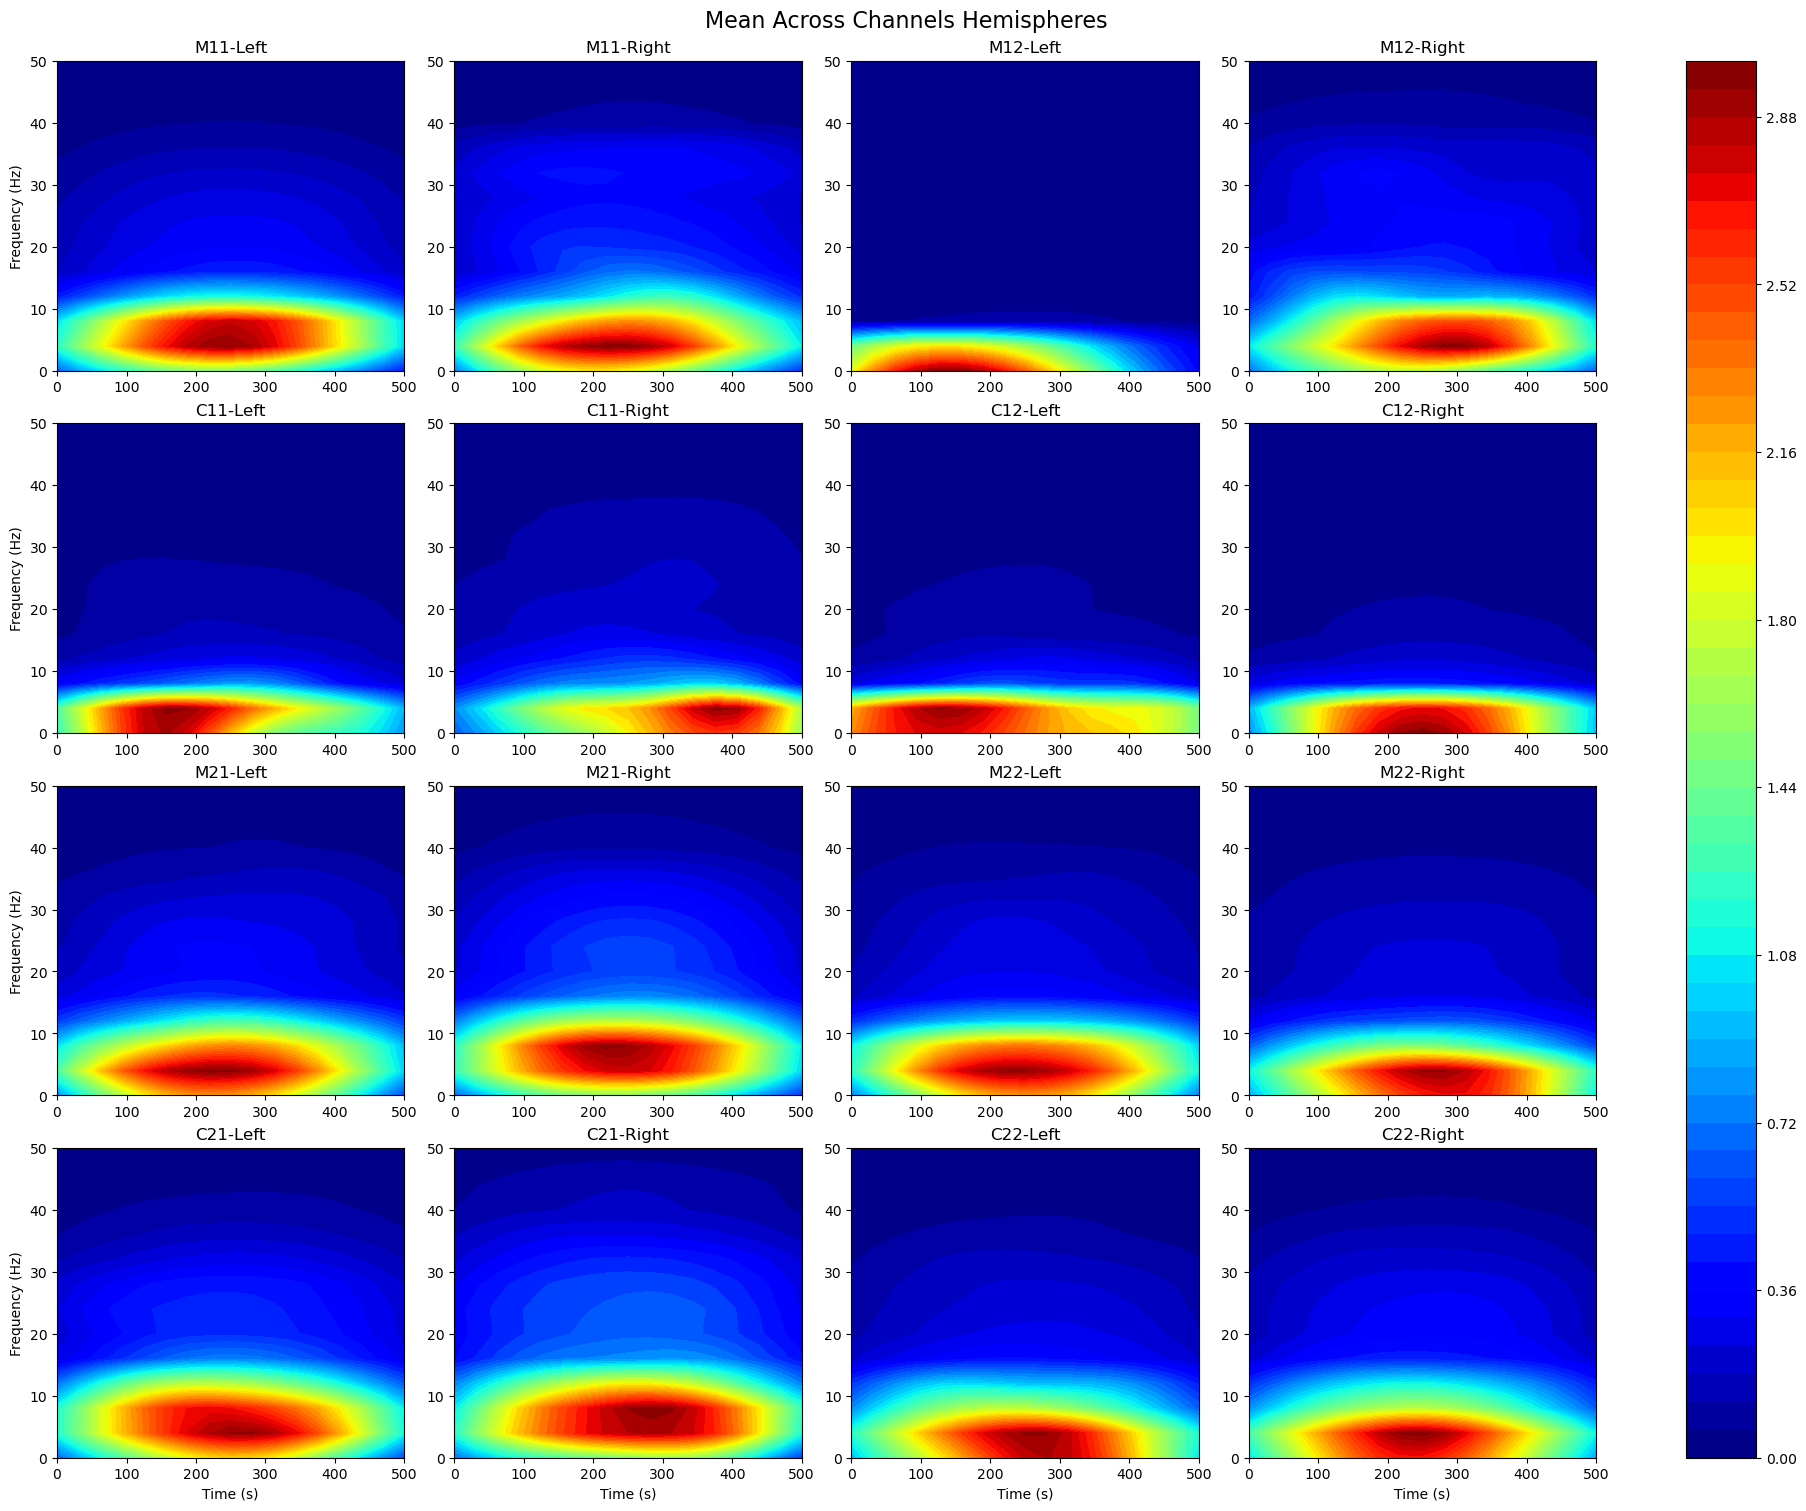

In [13]:
fig, ax = plt.subplots(4,4, figsize=(18,15), constrained_layout=True)
fig.suptitle('Mean Across Channels Hemispheres', fontsize=16)
ax[0,0].set_title('M11-Left')
ax[0,1].set_title('M11-Right')
ax[0,2].set_title('M12-Left')
ax[0,3].set_title('M12-Right')
ax[1,0].set_title('C11-Left')
ax[1,1].set_title('C11-Right')
ax[1,2].set_title('C12-Left')
ax[1,3].set_title('C12-Right')
ax[2,0].set_title('M21-Left')
ax[2,1].set_title('M21-Right')
ax[2,2].set_title('M22-Left')
ax[2,3].set_title('M22-Right')
ax[3,0].set_title('C21-Left')
ax[3,1].set_title('C21-Right')
ax[3,2].set_title('C22-Left')
ax[3,3].set_title('C22-Right')
ax[0,0].set_ylabel('Frequency (Hz)')
ax[1,0].set_ylabel('Frequency (Hz)')
ax[2,0].set_ylabel('Frequency (Hz)')
ax[3,0].set_ylabel('Frequency (Hz)')
ax[3,0].set_xlabel('Time (s)')
ax[3,1].set_xlabel('Time (s)')
ax[3,2].set_xlabel('Time (s)')
ax[3,3].set_xlabel('Time (s)')
ax[0,0].set_ylim(0,50)
ax[0,1].set_ylim(0,50)
ax[0,2].set_ylim(0,50)
ax[0,3].set_ylim(0,50)
ax[1,0].set_ylim(0,50)
ax[1,1].set_ylim(0,50)
ax[1,2].set_ylim(0,50)
ax[1,3].set_ylim(0,50)
ax[2,0].set_ylim(0,50)
ax[2,1].set_ylim(0,50)
ax[2,2].set_ylim(0,50)
ax[2,3].set_ylim(0,50)
ax[3,0].set_ylim(0,50)
ax[3,1].set_ylim(0,50)
ax[3,2].set_ylim(0,50)
ax[3,3].set_ylim(0,50)
levels = 50
spectrum = ax[0,0].contourf(time, freqs, hleftM11,levels,cmap='jet')
spectrum = ax[0,1].contourf(time, freqs, hrightM11,levels,cmap='jet')
spectrum = ax[0,2].contourf(time, freqs, hleftM12,levels,cmap='jet')
spectrum = ax[0,3].contourf(time, freqs, hrightM12,levels,cmap='jet')
spectrum = ax[1,0].contourf(time, freqs, hleftC11,levels,cmap='jet')
spectrum = ax[1,1].contourf(time, freqs, hrightC11,levels,cmap='jet')
spectrum = ax[1,2].contourf(time, freqs, hleftC12,levels,cmap='jet')
spectrum = ax[1,3].contourf(time, freqs, hrightC12,levels,cmap='jet')
spectrum = ax[2,0].contourf(time, freqs, hleftM21,levels,cmap='jet')
spectrum = ax[2,1].contourf(time, freqs, hrightM21,levels,cmap='jet')
spectrum = ax[2,2].contourf(time, freqs, hleftM22,levels,cmap='jet')
spectrum = ax[2,3].contourf(time, freqs, hrightM22,levels,cmap='jet')
spectrum = ax[3,0].contourf(time, freqs, hleftC21,levels,cmap='jet')
spectrum = ax[3,1].contourf(time, freqs, hrightC21,levels,cmap='jet')
spectrum = ax[3,2].contourf(time, freqs, hleftC22,levels,cmap='jet')
spectrum = ax[3,3].contourf(time, freqs, hrightC22,levels,cmap='jet')
fig.colorbar(spectrum, ax=ax.ravel().tolist())
plt.show()